In [1]:
library(Seurat)
library(plyr)
library(dplyr)
#library(reticulate)
#library(Matrix)
library(stringr)
library(reshape2)
library(ggplot2)
library(biomaRt)
library(wesanderson)
library(Rmisc)

options(repr.plot.width=10, repr.plot.height=10)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
setwd("/home/jovyan/DWLS")
source('./Deconvolution_functions.R')

Loading required package: quadprog

Loading required package: reshape


Attaching package: ‘reshape’


The following objects are masked from ‘package:reshape2’:

    colsplit, melt, recast


The following object is masked from ‘package:dplyr’:

    rename


The following objects are masked from ‘package:plyr’:

    rename, round_any


Loading required package: e1071

Loading required package: ROCR

Loading required package: varhandle

Loading required package: MAST

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count


The following object is masked from ‘package:plyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCu

In [6]:
#Morgan data - load bulk data and convert ENSG to gene name to name scRNAseq data

setwd("/home/jovyan/data/GCA/bulk_RNA_deconvolution")
bulk<-read.csv("gene_expression_data.csv", row.names = 1)

ensembl_gene = useMart("ensembl", dataset="hsapiens_gene_ensembl")

#spare option if mart is down
#ensembl_gene <- useMart("ENSEMBL_MART_ENSEMBL", host="https://grch37.ensembl.org", path="/biomart/martservice", dataset = "hsapiens_gene_ensembl")

t2g<-biomaRt::getBM(attributes=c("external_gene_name", "ensembl_gene_id"), mart=ensembl_gene)

bulk$ensembl_gene_id<-rownames(bulk)
bulk<-merge(bulk, t2g, on = 'ensembl_gene_id')

bulk<-bulk[!(bulk$external_gene_name == ""),]

bulk$ensembl_gene_id<-NULL

bulk<-ddply(bulk, "external_gene_name", numcolwise(sum))

rownames(bulk)<-bulk$external_gene_name
bulk$external_gene_name<-NULL

setwd("/home/jovyan/data/GCA/bulk_RNA_deconvolution")
write.csv(bulk, 'gene_expression_data_gene_name.csv', row.names = TRUE)


***Restart***


In [21]:
#set up save structure in folder DWLS_results

workdir = "/home/jovyan/data/GCA/DWLS_results"
setwd(workdir)

dir.create(file.path(workdir, "data"), showWarnings = FALSE) #folder to store data
dir.create(file.path(workdir, "results"), showWarnings = FALSE) #folder to save results

In [4]:
#load single cell reference and limit to tissue and positive diagnosis only

setwd("/home/jovyan/data/GCA/R_conversion")
gca<-readRDS("GCA_R.RDS")


In [27]:
Idents(gca)<-'tissue'
tissue<-subset(gca, id = 'tissue')

In [28]:
Idents(tissue)<-'anno'
tissue<-subset(tissue, id = c('MyoFB_tissue','VSMC_tissue','Mac1_tissue','CD4_1_tissue','Transitional_tissue','NK_tissue','Mac2_tissue',
                            'Endothelium_2_tissue','Endothelium_1_tissue','CD8_tissue','Lymph_endo_tissue','CD4_2_tissue',
                            'DC_tissue','Epithelium_tissue','Plasma_tissue','CD4_exhausted_tissue',
                            'Melanocyte_tissue','Muscle_tissue'))


tissue<-subset(tissue, id = c('Epithelium_tissue', 'Melanocyte_tissue','Muscle_tissue', 
                              'Plasma_tissue', 'Transitional_tissue', 'Lymph_endo_tissue'), invert = TRUE)

In [29]:
anno<-'anno'

tissue@meta.data[[anno]][tissue@meta.data[[anno]] == 'CD4_1_tissue']<-'CD4'
tissue@meta.data[[anno]][tissue@meta.data[[anno]] == 'CD4_2_tissue']<-'CD4'
tissue@meta.data[[anno]][tissue@meta.data[[anno]] == 'CD4_exhausted_tissue']<-'CD4'
tissue@meta.data[[anno]][tissue@meta.data[[anno]] == 'CD8_tissue']<-'CD8'
tissue@meta.data[[anno]][tissue@meta.data[[anno]] == 'NK_tissue']<-'NK'

tissue@meta.data[[anno]][tissue@meta.data[[anno]] == 'MyoFB_tissue']<-'MyoFB'
tissue@meta.data[[anno]][tissue@meta.data[[anno]] == 'VSMC_tissue']<-'VSMC'

tissue@meta.data[[anno]][tissue@meta.data[[anno]] == 'Endothelium_1_tissue']<-'Endothelium'
tissue@meta.data[[anno]][tissue@meta.data[[anno]] == 'Endothelium_2_tissue']<-'Endothelium'


tissue@meta.data[[anno]][tissue@meta.data[[anno]] == 'Mac1_tissue']<-'Mac'
tissue@meta.data[[anno]][tissue@meta.data[[anno]] == 'Mac2_tissue']<-'Mac'
tissue@meta.data[[anno]][tissue@meta.data[[anno]] == 'DC_tissue']<-'DC'




In [31]:
tissue <- NormalizeData(tissue)
tissue <- FindVariableFeatures(tissue, selection.method = "vst", nfeatures = 3000)

In [32]:
tissue_sc_data<-GetAssayData(object = tissue, slot = 'counts')

In [33]:
tissue_sc_data<-tissue_sc_data[VariableFeatures(tissue),]

In [34]:
setwd(workdir)
Signature<-buildSignatureMatrixMAST(scdata=as.data.frame(tissue_sc_data),
                                    id=tissue@meta.data[[anno]],
                                    path="results",
                                    diff.cutoff=0.5,
                                    pval.cutoff=0.01)

Using  as id variables

No dimnames in `exprsArray`, assuming `fData` and `cData` are sorted according to `exprsArray`

Assuming data assay in position 1, with name Et is log-transformed.


Done!



Fitted zlm on 1073 genes and 18325 cells.
 Using BayesGLMlike ~ Population 


Combining coefficients and standard errors

Calculating log-fold changes

Refitting on reduced model...


Done!

Using  as id variables

No dimnames in `exprsArray`, assuming `fData` and `cData` are sorted according to `exprsArray`

Assuming data assay in position 1, with name Et is log-transformed.


Done!



Fitted zlm on 47 genes and 18325 cells.
 Using BayesGLMlike ~ Population 


Combining coefficients and standard errors

Calculating log-fold changes

Refitting on reduced model...


Done!

Using  as id variables

No dimnames in `exprsArray`, assuming `fData` and `cData` are sorted according to `exprsArray`

Assuming data assay in position 1, with name Et is log-transformed.


Done!



Fitted zlm on 541 genes and 18325 cells.
 Using BayesGLMlike ~ Population 


Combining coefficients and standard errors

Calculating log-fold changes

Refitting on reduced model...


Done!

Using  as id variables

No dimnames in `exprsArray`, assuming `fData` and `cData` are sorted according to `exprsArray`

Assuming data assay in position 1, with name Et is log-transformed.


Done!



Fitted zlm on 137 genes and 18325 cells.
 Using BayesGLMlike ~ Population 


Combining coefficients and standard errors

Calculating log-fold changes

Refitting on reduced model...


Done!

Using  as id variables

No dimnames in `exprsArray`, assuming `fData` and `cData` are sorted according to `exprsArray`

Assuming data assay in position 1, with name Et is log-transformed.


Done!



Fitted zlm on 237 genes and 18325 cells.
 Using BayesGLMlike ~ Population 


Combining coefficients and standard errors

Calculating log-fold changes

Refitting on reduced model...


Done!

Using  as id variables

No dimnames in `exprsArray`, assuming `fData` and `cData` are sorted according to `exprsArray`

Assuming data assay in position 1, with name Et is log-transformed.


Done!



Fitted zlm on 1033 genes and 18325 cells.
 Using BayesGLMlike ~ Population 


Combining coefficients and standard errors

Calculating log-fold changes

Refitting on reduced model...


Done!

Using  as id variables

No dimnames in `exprsArray`, assuming `fData` and `cData` are sorted according to `exprsArray`

Assuming data assay in position 1, with name Et is log-transformed.


Done!



Fitted zlm on 280 genes and 18325 cells.
 Using BayesGLMlike ~ Population 


Combining coefficients and standard errors

Calculating log-fold changes

Refitting on reduced model...


Done!

Using  as id variables

No dimnames in `exprsArray`, assuming `fData` and `cData` are sorted according to `exprsArray`

Assuming data assay in position 1, with name Et is log-transformed.


Done!



Fitted zlm on 70 genes and 18325 cells.
 Using BayesGLMlike ~ Population 


Combining coefficients and standard errors

Calculating log-fold changes

Refitting on reduced model...


Done!



In [35]:
setwd("/home/jovyan/data/GCA/DWLS_results")
saveRDS(Signature, 'signature.RDS')


***Use signature with the Nagal bulk***


In [177]:
setwd("/home/jovyan/data/GCA/DWLS_results")
Signature<-readRDS('signature.RDS')

In [ ]:
#load bulk data with gene name annotation

setwd("/home/jovyan/data/GCA/bulk_RNA_deconvolution")
bulk<-read.csv('GSE174694_matrix_temposeq.txt', row.names = 1, sep = '\t')

In [40]:
deconv<-data.frame(row.names = colnames(Signature))
for (i in 1:length(unique(colnames(bulk)))){
    sample_temp<-bulk[[i]]
    names(sample_temp)<-rownames(bulk)
    tr<-trimData(Signature, sample_temp)
    solDWLS_temp<-data.frame(solveDampenedWLS(tr$sig,tr$bulk))
    colnames(solDWLS_temp)<-colnames(bulk)[i]
    deconv[i]<-solDWLS_temp
   
}

setwd("/home/jovyan/data/GCA/DWLS_results")

write.csv(deconv, 'DWLS_predicted_proportions_Nagal.csv')

      MyoFB        VSMC         Mac         CD4          NK Endothelium 
    0.02833     0.83030     0.07448     0.02586     0.00000     0.04102 
        CD8          DC 
    0.00000     0.00000 
      MyoFB        VSMC         Mac         CD4          NK Endothelium 
    0.06878     0.47421     0.26834     0.12520     0.00000     0.06347 
        CD8          DC 
    0.00000     0.00000 
      MyoFB        VSMC         Mac         CD4          NK Endothelium 
    0.06026     0.57567     0.27835     0.02363     0.00000     0.06209 
        CD8          DC 
    0.00000     0.00000 
      MyoFB        VSMC         Mac         CD4          NK Endothelium 
    0.03964     0.58283     0.23676     0.11544     0.00000     0.02533 
        CD8          DC 
    0.00000     0.00000 
      MyoFB        VSMC         Mac         CD4          NK Endothelium 
    0.05761     0.68373     0.20264     0.02482     0.00000     0.03120 
        CD8          DC 
    0.00000     0.00000 
      MyoFB        V


***Restart with plotting***


In [3]:
#Function for grouping variables on one line

# Generic form
'%=%' = function(l, r, ...) UseMethod('%=%')

# Binary Operator
'%=%.lbunch' = function(l, r, ...) {
  Envir = as.environment(-1)

  if (length(r) > length(l))
    warning("RHS has more args than LHS. Only first", length(l), "used.")

  if (length(l) > length(r))  {
    warning("LHS has more args than RHS. RHS will be repeated.")
    r <- extendToMatch(r, l)
  }

  for (II in 1:length(l)) {
    do.call('<-', list(l[[II]], r[[II]]), envir=Envir)
  }
}

# Used if LHS is larger than RHS
extendToMatch <- function(source, destin) {
  s <- length(source)
  d <- length(destin)

  # Assume that destin is a length when it is a single number and source is not
  if(d==1 && s>1 && !is.null(as.numeric(destin)))
    d <- destin

  dif <- d - s
  if (dif > 0) {
    source <- rep(source, ceiling(d/s))[1:d]
  }
  return (source)
}
# Grouping the left hand side
g = function(...) {
  List = as.list(substitute(list(...)))[-1L]
  class(List) = 'lbunch'
  return(List)
}

In [4]:
#import deconvolution predictions

setwd("/home/jovyan/data/GCA/DWLS_results")
deconv<-read.csv('DWLS_predicted_proportions_Nagal.csv', row.names = 1)

In [5]:
#Nagal cohort

setwd("/home/jovyan/data/GCA/bulk_RNA_deconvolution")
bulk<-read.csv('GSE174694_matrix_temposeq.txt', row.names = 1, sep = '\t')

In [6]:
#import clinical metadata

#add metadata
metadata<-data.frame(sample = colnames(bulk), diagnosis = sapply(strsplit(colnames(bulk), split = '[.]'), "[", 1))
rownames(metadata)<-metadata$sample
metadata$sample<-NULL


In [7]:
#Choose metadata
#g(Status, Status1, Status2) %=% c('diagnosis', 'NOT', 'GCA')

g(Status, Status1, Status2) %=% c('diagnosis', 'NORMAL', 'GCA')

In [8]:
#format data
deconv<-as.data.frame(t(deconv))
deconv[Status]<-metadata[Status]


deconv$X<-NULL
deconv<-melt(deconv, id = Status)
colnames(deconv)<-c(paste0(Status), 'celltype', 'props')
deconv$props <- as.numeric(deconv$props)

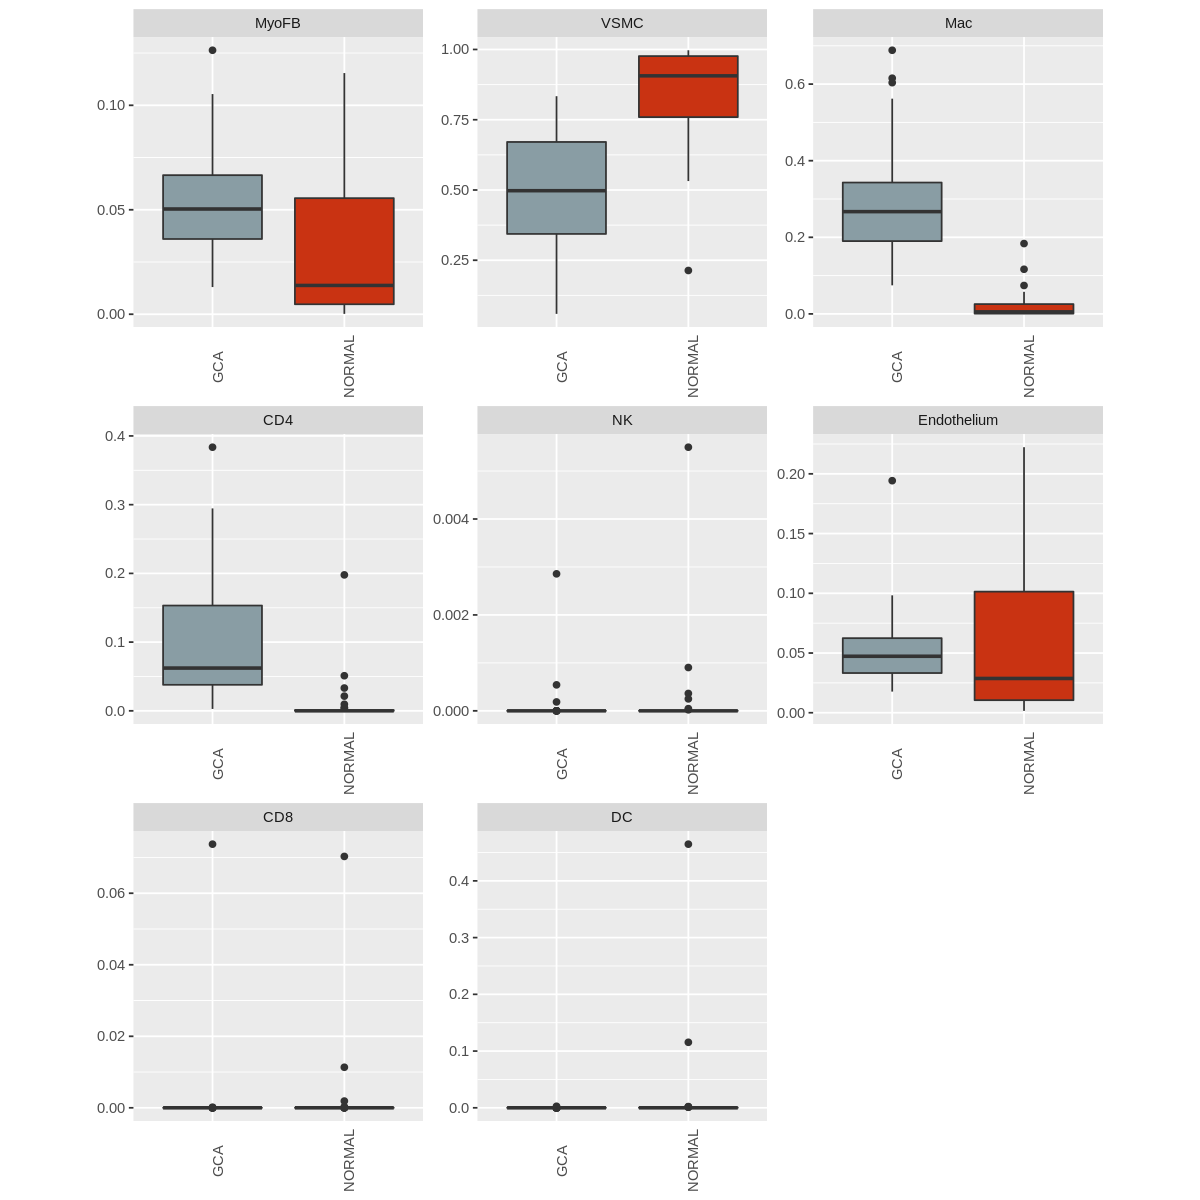

In [9]:
#labelled plot

ggplot(data=deconv, aes_string(x=Status, y='props', fill=Status)) +
    geom_boxplot() +
scale_fill_manual(values = wes_palette("Royal1"))+
      theme(aspect.ratio = 1/1) + 
facet_wrap(~celltype, scales = "free")+
theme(axis.text.x = element_text(angle = 90)) +
theme(axis.title.x=element_blank(),
       #axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
#           axis.text.y=element_blank(),
      axis.title.y=element_blank()) +
theme(legend.position="none") 

In [10]:
celltypes<-unique(deconv$celltype)

l<-list()
for(i in unique(celltypes)){
    temp<-deconv %>% filter(celltype == i)
    if (nrow(temp[temp$diagnosis == 'GCA',])>2 & nrow(temp[temp$diagnosis == 'NORMAL',])>2){
        temp_result<-wilcox.test(filter(temp, !!as.symbol(Status) == Status1)$props, filter(temp, !!as.symbol(Status) == Status2)$props, alternative = "two.sided")
        l[i]<-temp_result$p.value}
    else
        next
}

Warning message in wilcox.test.default(filter(temp, !!as.symbol(Status) == Status1)$props, :
“cannot compute exact p-value with ties”


In [11]:
l

$MyoFB
[1] 0.0008902961

$VSMC
[1] 1.803869e-11

$Mac
[1] 5.884943e-18

$CD4
[1] 2.211566e-13

$NK
[1] 0.01448894

$Endothelium
[1] 0.2363411

$CD8
[1] 0.4927054

$DC
[1] 0.02955778

In [11]:
deconv$celltype<-factor(deconv$celltype, levels = c('CD4', 'CD8', 'NK', 'DC', 'Mac',
                                                   'VSMC', 'MyoFB', 'Endothelium'))

Warning message:
“Removed 79 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 79 rows containing missing values (geom_point).”
Warning message:
“Removed 79 rows containing missing values (geom_point).”


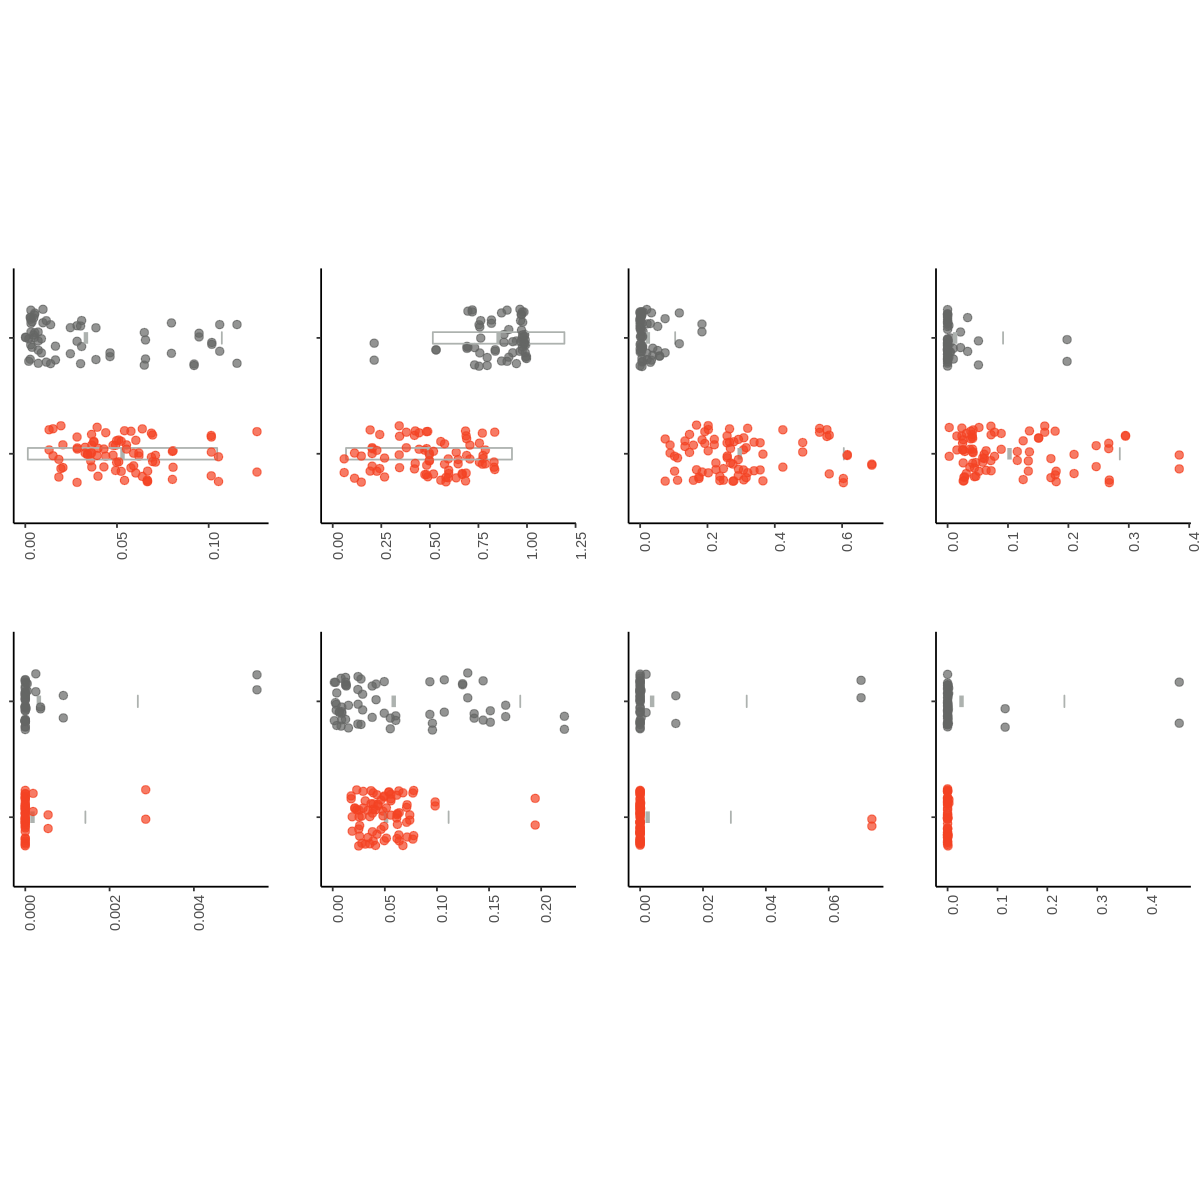

In [43]:
#labelled plot

ggplot(data=deconv, aes_string(x=Status, y='props')) +
geom_point(aes_string(fill = Status, color = Status), 
           size = 2, alpha = 0.7, 
           position = position_jitter(width=0.25, height=0)) +
  facet_wrap(~ celltype, scales = 'free', ncol = 4) + coord_flip()+
scale_color_manual(values = c('#f44323', '#656665')) + 
theme(aspect.ratio = 1/1) + 
stat_summary(fun.data="mean_sdl", fun.max = list(mult=1),
                 geom="crossbar", width=0.1, color = '#ADB2AF')+
geom_point(aes_string(fill = Status, color = Status), 
           size = 2, alpha = 0.7, 
           position = position_jitter(width=0.25, height=0)) +
theme(axis.text.x = element_text(angle = 90)) +
theme(axis.title.x=element_blank(),
#       axis.text.x=element_blank(),
#        axis.ticks.x=element_blank(),
           axis.text.y=element_blank(),
      axis.title.y=element_blank()) +
theme(legend.position="none") +
theme(strip.background = element_blank(), 
     strip.text.x = element_blank(),
     panel.spacing.y = unit(3, "lines"), panel.spacing.x = unit(2, "lines"))+
scale_y_continuous(limits = c(0,NA))+

theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))


setwd("/home/jovyan/data/GCA/figures")

ggsave("DWLS_plotting_bulk_deconvolution.png",   dpi = 300)

In [36]:
list(mult = 1)

$mult
[1] 1